## Challenge Description

We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.

As said above, the goal is to predict employee retention and understand its main drivers. Specifically, you should:

  * Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id


  * What are the main factors that drive employee churn? Do they make sense? Explain your findings


  * If you could add to this data set just one variable that could help explain employee churn, what would that be?


### Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import  warnings
warnings.simplefilter('ignore')

In [2]:
retention = pd.read_csv('employee_retention.csv')

In [3]:
retention.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
retention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


---

<font size=5>Question 1:
    
    Estimate employee headcount, for each company on each day, from 2011/01/24 to 2015/12/13.

In [5]:
# convert date variables to datetime format
retention['join_date'] = pd.to_datetime(retention['join_date'])
retention['quit_date'] = pd.to_datetime(retention['quit_date'])

In [6]:
# generate all dates
dates = pd.date_range('2011-01-24','2015-12-13')

# generate a list of unique company ids
company = retention['company_id'].unique()

# cross join dates and company
dates = pd.DataFrame(dates, columns=['dates'])
company = pd.DataFrame(company, columns=['company_id'])
dates['key'] = 0
company['key'] = 0
table = pd.merge(dates, company, on='key', how='outer')
table = table.drop('key',axis=1)
table.head()

,dates,company_id
0,2011-01-24,7
1,2011-01-24,4
2,2011-01-24,2
3,2011-01-24,9
4,2011-01-24,1


In [7]:
# calculate how many employees joined for each company each day
joined = retention.groupby(['join_date','company_id']).size().to_frame('join_count').reset_index()

# calculate how many employees quited for each company each day
quited = retention.groupby(['quit_date','company_id']).size().to_frame('quit_count').reset_index()

In [8]:
# merge the three tables
data = pd.merge(table, joined, left_on = ['dates','company_id'], right_on = ['join_date','company_id'], how='left')
data = pd.merge(data, quited, left_on=['dates','company_id'],right_on=['quit_date','company_id'], how='left')
data = data.drop(['join_date','quit_date'],axis=1)

In [9]:
# fill the na values into 0
data.join_count = data.join_count.fillna(0)
data.quit_count = data.quit_count.fillna(0)
data.head()

,dates,company_id,join_count,quit_count
0,2011-01-24,7,1.0,0.0
1,2011-01-24,4,12.0,0.0
2,2011-01-24,2,17.0,0.0
3,2011-01-24,9,3.0,0.0
4,2011-01-24,1,25.0,0.0


In [10]:
# calculate cumulative join counts and quit counts for each company each day
data['cum_join'] = data.groupby('company_id').join_count.cumsum()
data['cum_quit'] = data.groupby('company_id').quit_count.cumsum()

In [11]:
# calculate headcount for each company each day
data['headcount'] = data['cum_join'] - data['cum_quit']

# final table
headcounts = data[['dates','company_id','headcount']]
headcounts.columns = ['day','company_id','employee_headcount']
headcounts.sort_values(by=['company_id','day']).head()

,day,company_id,employee_headcount
4,2011-01-24,1,25.0
16,2011-01-25,1,27.0
28,2011-01-26,1,29.0
40,2011-01-27,1,29.0
52,2011-01-28,1,29.0


---

<font size=5>Question 2:
    
    What are the main factors that drive employee churn? Do they make sense? Explain your findings

In [12]:
# how many days employees stay in their companies
retention['stays'] = retention['quit_date'] - retention['join_date']
retention['stays'] = retention['stays'].apply(lambda x: x.days)

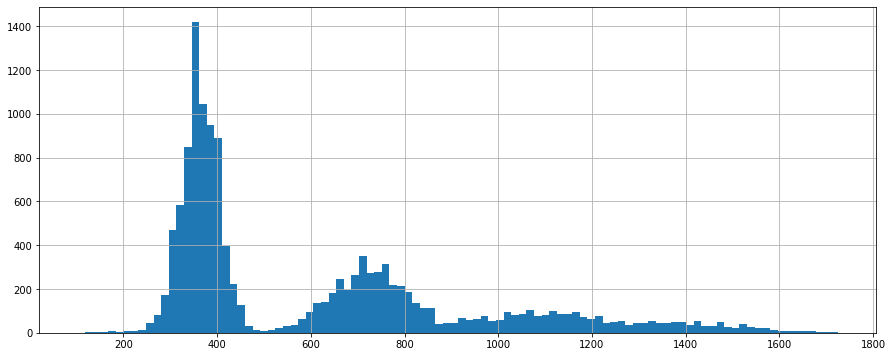

In [13]:
plt.figure(figsize=(15,6))
retention['stays'].dropna().hist(bins=100)
plt.show()

<font size=5>
    
    From the above chart, we can see that employees are churned more around their year anniversaries.

In [14]:
retention['quit_weekday'] = retention['quit_date'].dt.weekday
retention['quit_season'] = retention['quit_date'].dt.quarter
retention['quit_month'] = retention['quit_date'].dt.month

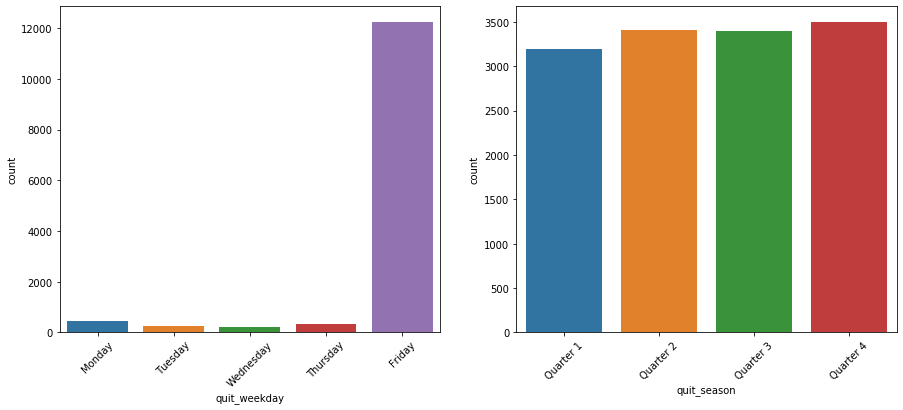

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.countplot(x = retention.quit_weekday.dropna(), ax=ax[0])
sns.countplot(x = retention.quit_season.dropna(), ax=ax[1])
ax[0].set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday'], rotation=45, fontsize=10)
ax[1].set_xticklabels(['Quarter 1','Quarter 2','Quarter 3','Quarter 4'], rotation=45, fontsize=10)
plt.show()

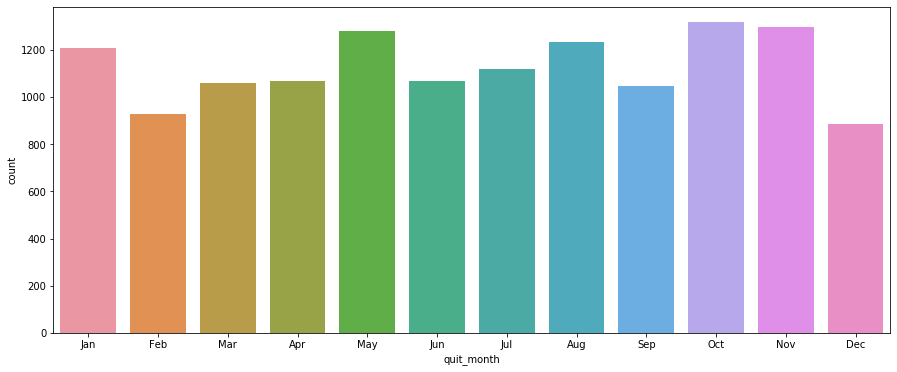

In [16]:
plt.figure(figsize=(15,6))
ax = sns.countplot(x = retention['quit_month'].dropna())
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], fontsize=10)
plt.show()

<font size=4>
    
    From the above chart, we can see that almost all the employees quit on Friday, and there are a little bit more employees quit on Octorber and November.
    
    From the above charts, we can define that employees quit within 13 months are early quitters. So we can create binary class: employees quit within 13 months or not.

<font size=5>
    
    Let's build a model to figure out what main factors that drive employee churn.

In [17]:
# remove employees who are not stay in the current company over 13 months
retention['join_till_now_days'] = (pd.to_datetime('2015-12-13') - retention['join_date']).dt.days
data = retention.drop(retention[retention['join_till_now_days']<(365+31)].index, axis=0)

In [18]:
# create target variable: quit or no quit
data.loc[data['quit_date'].isna(),'quit_date'] = 0
data.loc[data['quit_date']!=0, 'quit_date'] = 1

In [19]:
# get features to build the model
features = ['dept','seniority','salary','company_id']
X = data[features]
y = data['quit_date']

In [20]:
y.value_counts()

1    13333
0     5943
Name: quit_date, dtype: int64

### dummy variables

In [21]:
X = pd.get_dummies(X, drop_first=True)

### build model

<font size=4>
    
    we are not too interested in predictive power, we are mainly using the tree as a descriptive stat tool

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=30, class_weight='balanced', min_impurity_decrease=0.001)
tree.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

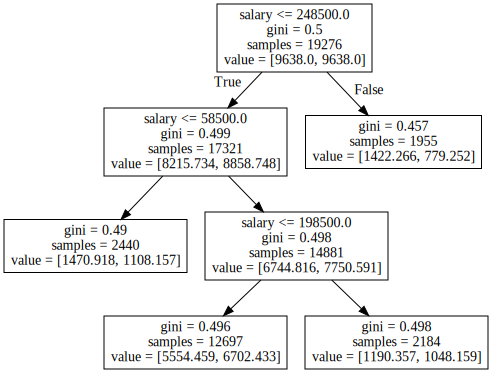

In [23]:
# visualize it
dot_data = export_graphviz(tree, out_file = None, feature_names = X.columns)
graph = graphviz.Source(dot_data)
graph

<font size=4>
    
    We can see that salary is the most important factor.
    
    The way the tree split is: If salary between 248500 and 58500, the employee has higher probability of being an early quitter. That is, that’s a leaf that predicts class 1. Otherwise, the other two nodes predict class 0, which are >248500 and <58500. That means that people who make a lot of money and very little are not likely to quit

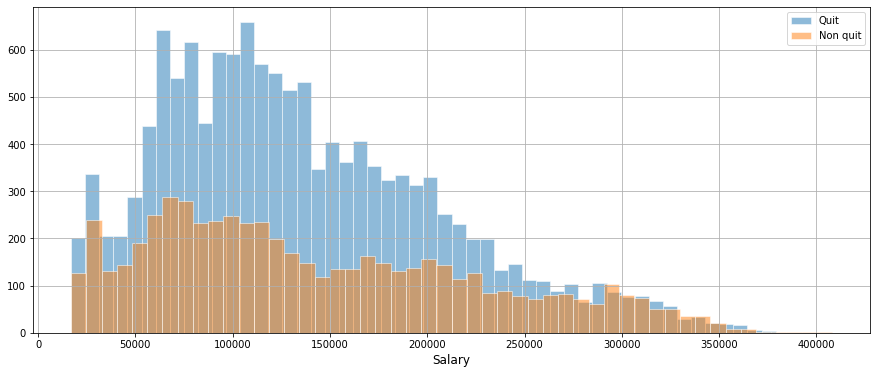

In [24]:
fig, ax = plt.subplots(figsize=(15,6))
data[data['quit_date']==1]['salary'].hist(bins=50, alpha=0.5, edgecolor = 'white', ax=ax)
data[data['quit_date']==0]['salary'].hist(bins=50, alpha=0.5, edgecolor='white',ax=ax)
ax.set_xlabel('Salary',fontsize=12)
ax.legend(['Quit','Non quit'])
plt.show()

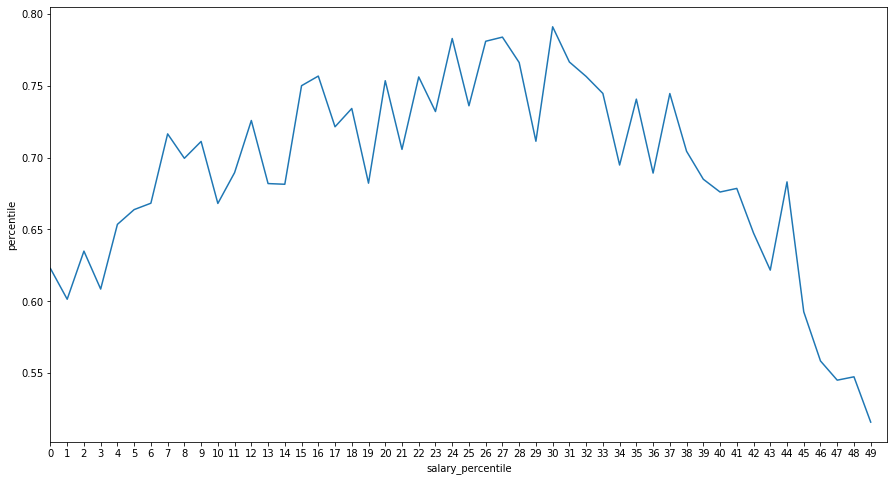

In [25]:
#convert salary to its percentiles. We break it into 50 bins.
data['salary_percentile'] = pd.qcut(data['salary'], q=50, labels=False)

percentile = data.groupby('salary_percentile')['quit_date'].mean().to_frame('percentile')

# visualize it
fig,ax=plt.subplots(figsize=(15,8))
sns.lineplot(x=percentile.index, y=percentile['percentile'],ax=ax)
ax.set_xlim(1,50)
ax.set_xticks(percentile.index)
plt.show()

---

# Conclusions

<font size=4>
    
    1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.

    2. The major findings are that employees quit at year anniversaries or at the begining of the year. Both cases make sense. Even if you don't like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the begining of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.

    3. Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.
    
    4. When building machine learning models on real data, you will find surprisingly often that one variable is way more important than the rest. We saw it in the conversion project too with number of pages visited. It is unlikely though that in real life one thing can explain complex phenomena. The most likely reason is that one variable is highly correlated with a lot of other variables. Like here, salary is obviously important, but especially because it is a proxy for so many other things (seniority, how marketable is someone, how much that person feels appreciated at work, etc). In these cases, assuming you have access to many other variables, try to get to the bottom of these relationships, by for instance building a model that predicts salary or removing salary and see which variables start to matter. After all, our model says that low salaries are less likely to quit. But definitely, it is not that if you reduce all salaries below 60K, retention will go up